In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from omegaconf import DictConfig, OmegaConf
import torch
from torch.utils.data import DataLoader, TensorDataset
import scipy.stats as stats
from tqdm import tqdm
from DataInit import DataManager, RewardDataManager
import DataInit

In [23]:
import numpy as np
import os

In [33]:
class Exp4DataManager:
    def __init__(self, config: DictConfig, data_path: Path, if_print_plot: bool=False) -> None:
        """
        """
        # 提取并保存配置项
        self.config = config
        self.data_path = data_path
        self.if_print_plot = if_print_plot
        self.reward_parameters = self.config.data_generation.reward_parameters

        # 初始化通用参数
        self.lambda_load: float = self.config.base.lambda_load
        self.top_k: list[int] = self.config.base.top_k
        self.N: int = self.config.base.N
        self.T_test: int = self.config.base.T_test

        # 保存reward_parameters_slider的相关参数到self
        self.iid_alpha_load_0= self.reward_parameters.iid.alpha_load_0
        self.iid_alpha_latency_1 = self.reward_parameters.iid.alpha_latency_1

        self.ar1_alpha_load_0 = self.reward_parameters.ar1.alpha_load_0
        self.ar1_alpha_latency_1 = self.reward_parameters.ar1.alpha_latency_1
        
        self.ar_data = self.ARDataManager(self)

        self.lstm_data = self.LSTMDataManager(self)

        self.gnn_data = self.GNNDataManager(self)

    class BaseDataManager:
        def __init__(self, exp4, load_paths: dict[str, Path], latency_paths: dict[str, Path]) -> None:
            self.exp4 = exp4

            # 加载预测数据
            self.iid_load_pred = pd.read_csv(load_paths['iid'], header=None).values
            self.ar1_load_pred = pd.read_csv(load_paths['ar1'], header=None).values
            self.iid_latency_pred = pd.read_csv(latency_paths['iid'], header=None).values
            self.ar1_latency_pred = pd.read_csv(latency_paths['ar1'], header=None).values

            # print(f"---------- ARDataManager Reward Data Info ----------")
            # print(f"iid_load_original.shape: {self.iid_load_pred.shape}")
            # print(f"iid_latency_original.shape: {self.iid_latency_pred.shape}")
            # print(f"ar1_load_original.shape: {self.ar1_load_pred.shape}")
            # print(f"ar1_latency_original.shape: {self.ar1_latency_pred.shape}")

            # 计算奖励
            self.iid_load_pred_reward_0, self.iid_load_pred_reward_1, self.iid_latency_pred_reward_1, \
                self.ar1_load_pred_reward_0, self.ar1_load_pred_reward_1, self.ar1_latency_pred_reward_1 = \
                self.exp4.calculate_expert_rewards(self.iid_load_pred, self.ar1_load_pred, self.iid_latency_pred, self.ar1_latency_pred)

            # print(f"iid_load_pred_reward_0.shape: {self.iid_load_pred_reward_0.shape}")
            # print(f"iid_load_pred_reward_1.shape: {self.iid_load_pred_reward_1.shape}")
            # print(f"iid_latency_pred_reward_1.shape: {self.iid_latency_pred_reward_1.shape}")
            # 
            # print(f"ar1_load_pred_reward_0.shape: {self.ar1_load_pred_reward_0.shape}")
            # print(f"ar1_load_pred_reward_1.shape: {self.ar1_load_pred_reward_1.shape}")
            # print(f"ar1_latency_pred_reward_1.shape: {self.ar1_latency_pred_reward_1.shape}")
            # print(f"--------------------------------------")

            # 定义映射字典
            self.reward_mapping = {
                ('iid', 'reward_0'): (self.iid_load_pred_reward_0, self.iid_latency_pred_reward_1),
                ('iid', 'reward_1'): (self.iid_load_pred_reward_1, self.iid_latency_pred_reward_1),
                ('ar1', 'reward_0'): (self.ar1_load_pred_reward_0, self.ar1_latency_pred_reward_1),
                ('ar1', 'reward_1'): (self.ar1_load_pred_reward_1, self.ar1_latency_pred_reward_1),
            }

            # 初始化其他参数
            self.load_reward_method = None
            self.data_type = None
            self.load_reward = None
            self.latency_reward = None
            self.combine_reward = None
            self.combine_reward_mean = None
            self.combine_reward_optimal_node = None
            self.combine_reward_optimal_mean = None
            self.combine_reward_sorted_mean = None

        def set_parameters(self, load_reward_method: str, data_type: str) -> None:
            # 设置参数并计算组合奖励
            self.load_reward_method = load_reward_method
            self.data_type = data_type
            try:
                self.load_reward, self.latency_reward = self.reward_mapping[(data_type, load_reward_method)]
            except KeyError:
                raise ValueError(f'Invalid load_reward_method: {load_reward_method}, data_type: {data_type}')

            # 计算组合奖励
            self.combine_reward = self.exp4.lambda_load * self.load_reward + (1 - self.exp4.lambda_load) * self.latency_reward
            self.combine_reward_mean = np.mean(self.combine_reward, axis=1)
            self.combine_reward_optimal_node = np.argmax(self.combine_reward_mean)
            self.combine_reward_optimal_mean = np.max(self.combine_reward_mean)
            self.combine_reward_sorted_mean = np.argsort(self.combine_reward_mean)[::-1]

    class ARDataManager(BaseDataManager):
        def __init__(self, exp4) -> None:
            load_paths = {
                'iid': exp4.data_path / 'exp4/AR_expert/AR_iid_load_predictions.csv',
                'ar1': exp4.data_path / 'exp4/AR_expert/AR_ar1_load_predictions.csv'
            }
            latency_paths = {
                'iid': exp4.data_path / 'exp4/AR_expert/AR_iid_latency_predictions.csv',
                'ar1': exp4.data_path / 'exp4/AR_expert/AR_ar1_latency_predictions.csv'
            }
            super().__init__(exp4, load_paths, latency_paths)
            if self.exp4.if_print_plot:
                print('================ AR Data Manager ================')
                self.exp4.print_info(self)
                self.exp4.plot_reward_data(self)
            
    class LSTMDataManager(BaseDataManager):
        def __init__(self, exp4) -> None:
            load_paths = {
                'iid': exp4.data_path / 'exp4/LSTM_expert/predictions/LSTM_iid_load_predictions.csv',
                'ar1': exp4.data_path / 'exp4/LSTM_expert/predictions/LSTM_ar1_load_predictions.csv'
            }
            latency_paths = {
                'iid': exp4.data_path / 'exp4/LSTM_expert/predictions/LSTM_iid_latency_predictions.csv',
                'ar1': exp4.data_path / 'exp4/LSTM_expert/predictions/LSTM_ar1_latency_predictions.csv'
            }
            super().__init__(exp4, load_paths, latency_paths)
            if self.exp4.if_print_plot:
                print('================ LSTM Data Manager ================')
                self.exp4.print_info(self)
                self.exp4.plot_reward_data(self)

    class GNNDataManager(BaseDataManager):
        def __init__(self, exp4) -> None:
            load_paths = {
                'iid': exp4.data_path / 'exp4/GNN_expert/predictions/GNN_iid_load_predictions.csv',
                'ar1': exp4.data_path / 'exp4/GNN_expert/predictions/GNN_ar1_load_predictions.csv'
            }
            latency_paths = {
                'iid': exp4.data_path / 'exp4/GNN_expert/predictions/GNN_iid_latency_predictions.csv',
                'ar1': exp4.data_path / 'exp4/GNN_expert/predictions/GNN_ar1_latency_predictions.csv'
            }
            super().__init__(exp4, load_paths, latency_paths)
            if self.exp4.if_print_plot:
                print('================ GNN Data Manager ================')
                self.exp4.print_info(self)
                self.exp4.plot_reward_data(self)

    def calculate_expert_rewards(self, iid_load_pred: np.ndarray, ar1_load_pred: np.ndarray, iid_latency_pred: np.ndarray, ar1_latency_pred: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

        # 计算reward数据
        iid_load_pred_reward_0 = self.calculate_reward(iid_load_pred, 'load_0')
        iid_load_pred_reward_1 = self.calculate_reward(iid_load_pred, 'load_1')
        iid_latency_pred_reward_1 = self.calculate_reward(iid_latency_pred, 'latency_1')

        ar1_load_pred_reward_0 = self.calculate_reward(ar1_load_pred, 'load_0')
        ar1_load_pred_reward_1 = self.calculate_reward(ar1_load_pred, 'load_1')
        ar1_latency_pred_reward_1 = self.calculate_reward(ar1_latency_pred, 'latency_1')
        
        return iid_load_pred_reward_0, iid_load_pred_reward_1, iid_latency_pred_reward_1, ar1_load_pred_reward_0, ar1_load_pred_reward_1, ar1_latency_pred_reward_1

    def calculate_reward(self, data: np.ndarray, method: str) -> np.ndarray:
        if method == 'load_0':
            return self.iid_alpha_load_0 / (1 + data)

        elif method == 'load_1':
            inverted_data = 1 / (1 + data)
            normalized_data = (inverted_data - inverted_data.min(axis=0)) / (inverted_data.max(axis=0) - inverted_data.min(axis=0))
            return normalized_data

        elif method == 'latency_1':
            return np.exp(-self.iid_alpha_latency_1 * data)
        else:
            raise ValueError(f"Unknown method: {method}")

    def print_info(self, expert):
        if not hasattr(expert, 'iid_load_pred'):
            raise ValueError(f"The provided expert does not have the required attributes.")
        print(f"---------- Reward Data Info ----------")
        print(f"iid_load_original.shape: {expert.iid_load_pred.shape}")
        print(f"iid_load_pred_reward_0.shape: {expert.iid_load_pred_reward_0.shape}")
        print(f"iid_load_pred_reward_1.shape: {expert.iid_load_pred_reward_1.shape}")
        print(f"iid_latency_original.shape: {expert.iid_latency_pred.shape}")
        print(f"iid_latency_pred_reward_1.shape: {expert.iid_latency_pred_reward_1.shape}")

        print(f"ar1_load_original.shape: {expert.ar1_load_pred.shape}")
        print(f"ar1_load_pred_reward_0.shape: {expert.ar1_load_pred_reward_0.shape}")
        print(f"ar1_load_pred_reward_1.shape: {expert.ar1_load_pred_reward_1.shape}")
        print(f"ar1_latency_original.shape: {expert.ar1_latency_pred.shape}")
        print(f"ar1_latency_pred_reward_1.shape: {expert.ar1_latency_pred_reward_1.shape}")
        print(f"--------------------------------------")

    def plot_reward_data(self, expert, start_node=0, end_node=2):
        # 检查节点索引是否合理
        if start_node < 0 or end_node >= expert.iid_load_pred.shape[0]:
            raise ValueError(f"Node indices must be within the range of 0 to {expert.iid_load_pred.shape[0] - 1}")

        # 绘制10*3个输出数据的折线图、直方图、均值图
        fig, axs = plt.subplots(10, 3, figsize=(18, 30))

        datasets = [
            ("Load IID Original", expert.iid_load_pred),
            ("Load IID Reward 0", expert.iid_load_pred_reward_0),
            ("Load IID Reward 1", expert.iid_load_pred_reward_1),
            ("Latency IID Original", expert.iid_latency_pred),
            ("Latency IID Reward 1", expert.iid_latency_pred_reward_1),
            ("Load AR1 Original", expert.ar1_load_pred),
            ("Load AR1 Reward 0", expert.ar1_load_pred_reward_0),
            ("Load AR1 Reward 1", expert.ar1_load_pred_reward_1),
            ("Latency AR1 Original", expert.ar1_latency_pred),
            ("Latency AR1 Reward 1", expert.ar1_latency_pred_reward_1)
        ]

        for idx, (title, data) in enumerate(datasets):
            self.plot_single_data(axs, data[start_node:end_node+1], data, row=idx, title=title, ylabel='Value', start_node=start_node)

        plt.tight_layout()
        plt.show()

    def plot_single_data(self, axs, partial_data, full_data, row, title, ylabel, start_node):
        # 绘制折线图
        for i in range(partial_data.shape[0]):
            axs[row, 0].plot(partial_data[i], label=f'Node {i + start_node}')
        axs[row, 0].set_title(f"{title} - Selected Nodes")
        axs[row, 0].set_xlabel('Time')
        axs[row, 0].set_ylabel(ylabel)
        axs[row, 0].legend()
        axs[row, 0].grid(True)

        # 绘制均值图 (使用全部节点)
        mean_values = np.mean(full_data, axis=1)
        axs[row, 1].plot(mean_values, marker='o', linestyle='-', color='b', label=f'Mean {ylabel} per Node')
        axs[row, 1].set_title(f'{title} - Mean Values (All Nodes)')
        axs[row, 1].set_xlabel('Node')
        axs[row, 1].set_ylabel(f'Mean {ylabel}')
        axs[row, 1].legend()
        axs[row, 1].grid(True)

        y_max = mean_values.max()
        y_min = mean_values.min()
        range_value = y_max - y_min

        axs[row, 1].text(len(mean_values) - 1, (y_max + y_min) / 2,
                         f'Range: {range_value:.3f}',
                         ha='right', va='center', fontsize=10, color='red')
        axs[row, 1].hlines([y_min, y_max], xmin=0, xmax=len(mean_values) - 1, colors='red', linestyles='--', label='Range')
        axs[row, 1].legend()

        # 绘制直方图
        for i in range(partial_data.shape[0]):
            axs[row, 2].hist(partial_data[i].flatten(), bins=30, alpha=0.2, label=f'Node {i + start_node}')
        axs[row, 2].set_title(f'{title} - Histogram (Selected Nodes)')
        axs[row, 2].set_xlabel(f'{ylabel} Value')
        axs[row, 2].set_ylabel('Frequency')
        axs[row, 2].legend()
        axs[row, 2].grid(True)

================ AR Data Manager ================
---------- Reward Data Info ----------
iid_load_original.shape: (10, 1000)
iid_load_pred_reward_0.shape: (10, 1000)
iid_load_pred_reward_1.shape: (10, 1000)
iid_latency_original.shape: (10, 1000)
iid_latency_pred_reward_1.shape: (10, 1000)
ar1_load_original.shape: (10, 1000)
ar1_load_pred_reward_0.shape: (10, 1000)
ar1_load_pred_reward_1.shape: (10, 1000)
ar1_latency_original.shape: (10, 1000)
ar1_latency_pred_reward_1.shape: (10, 1000)
--------------------------------------


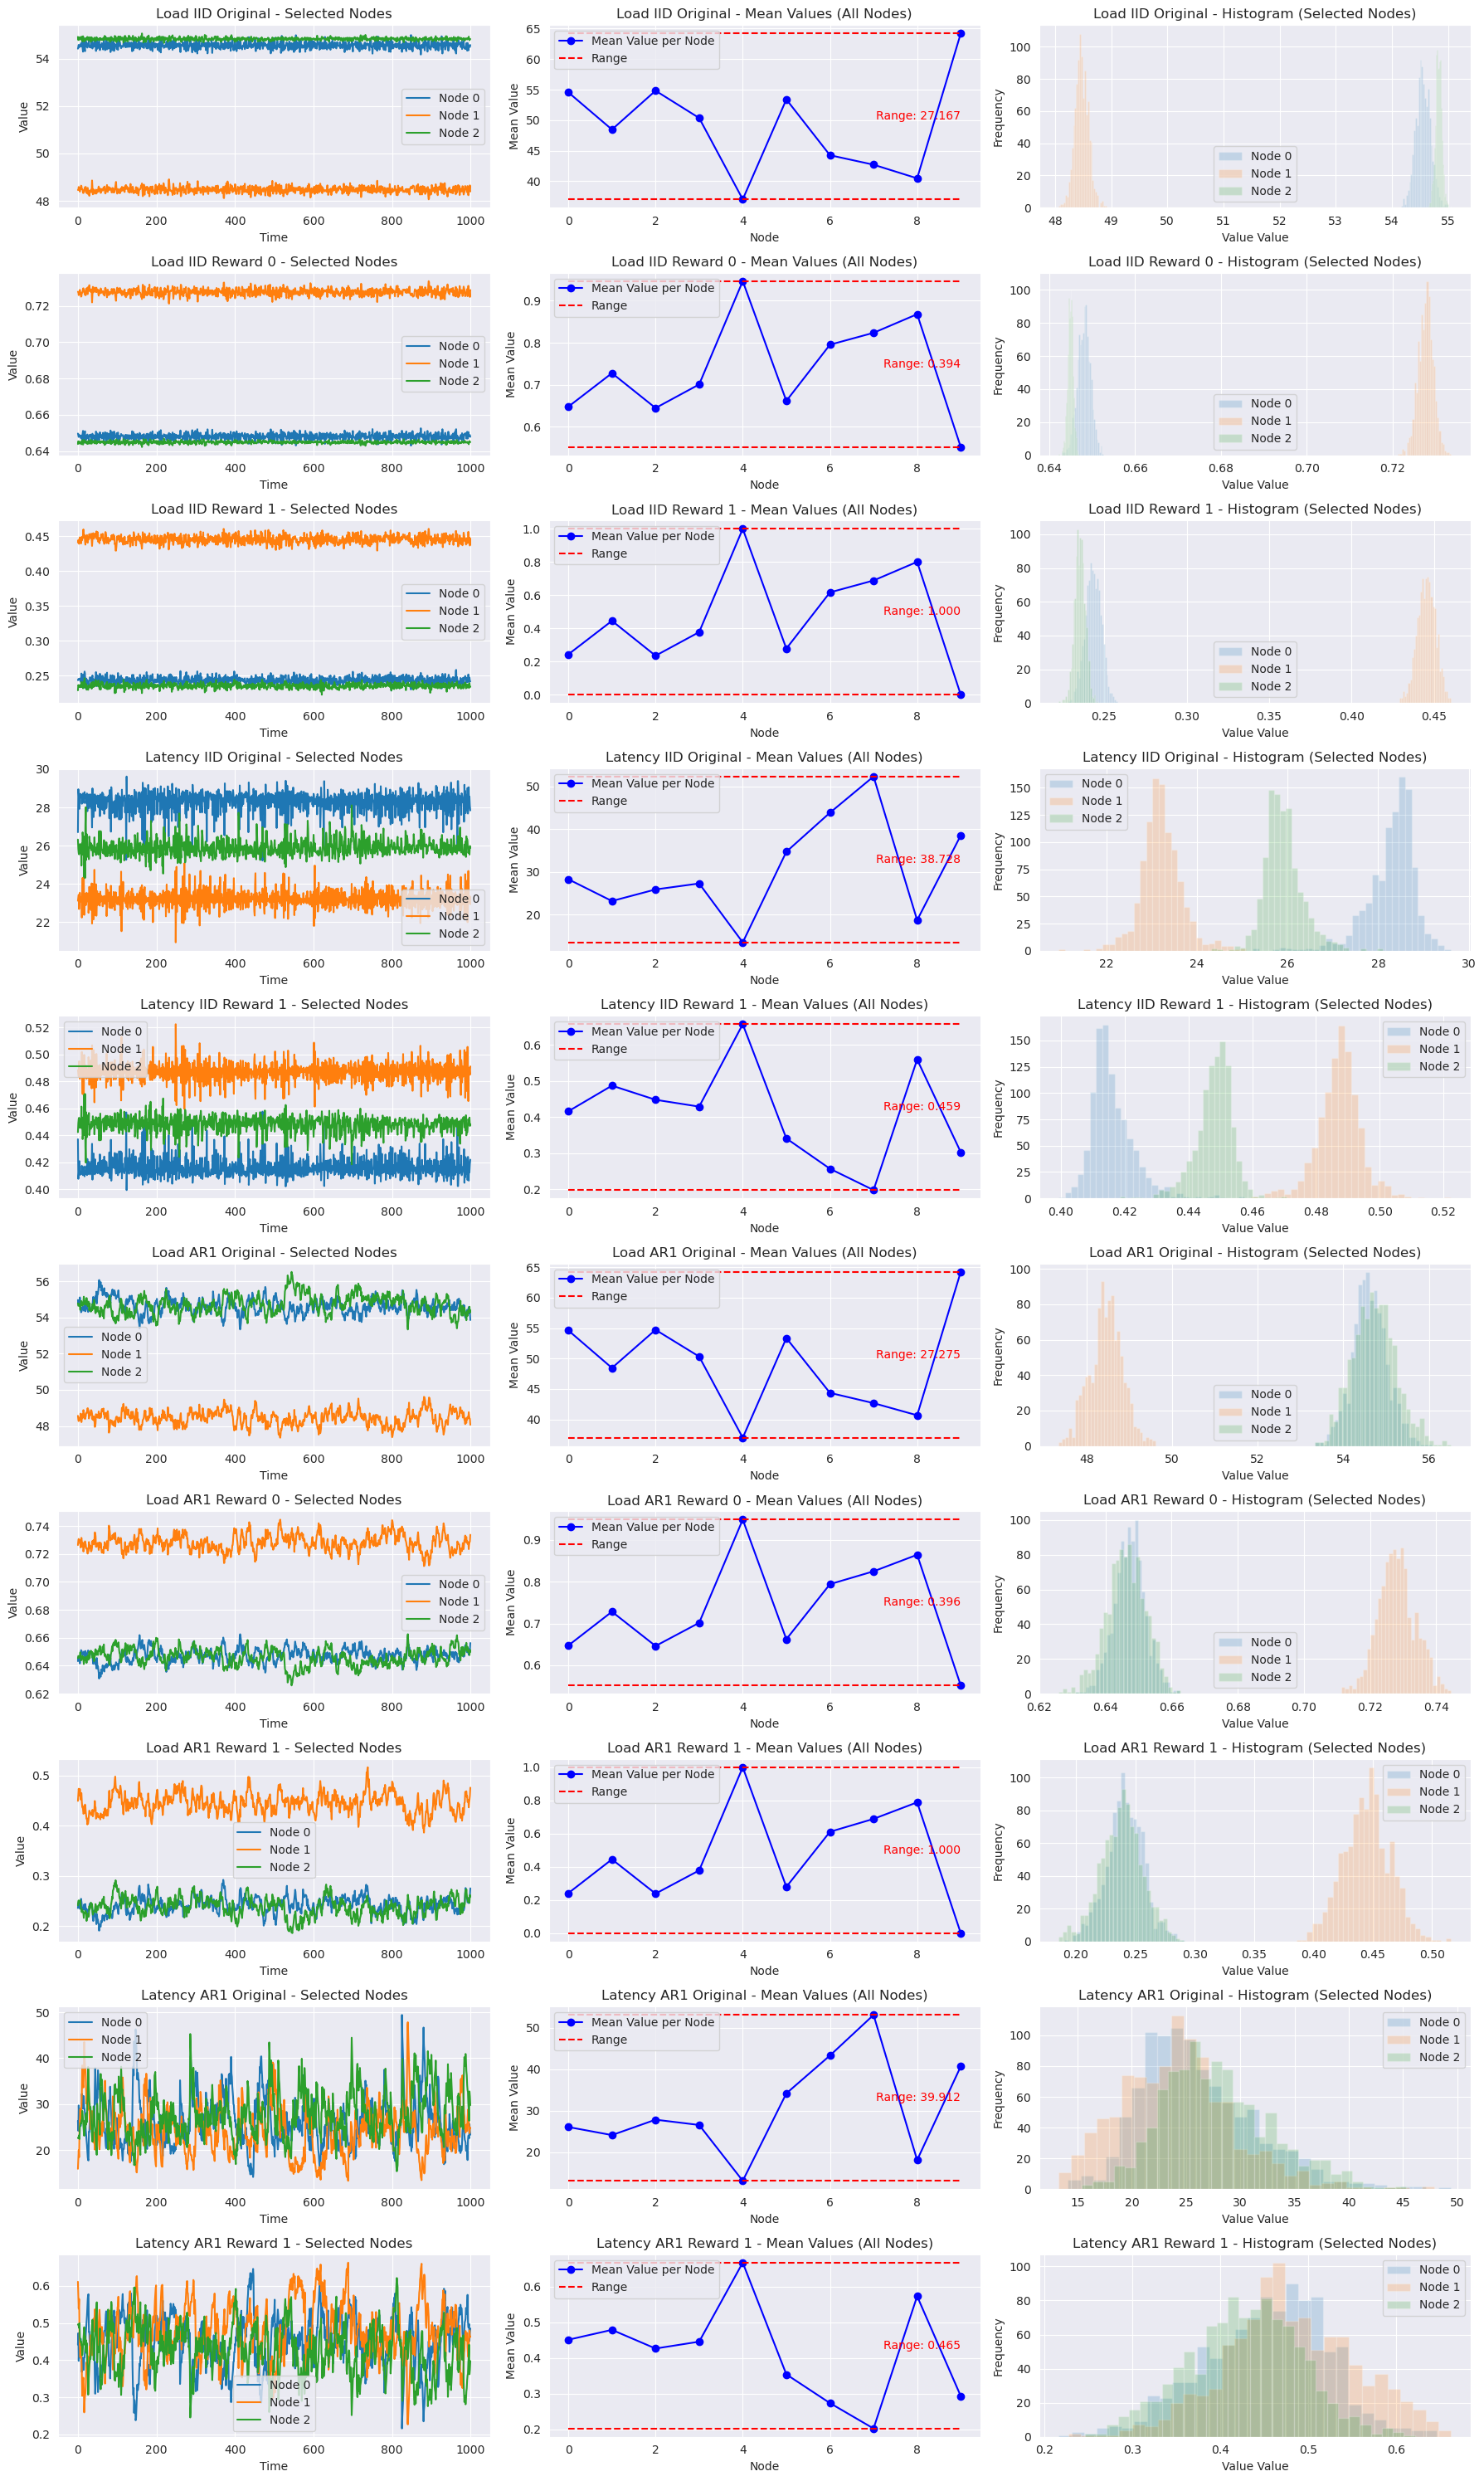

================ LSTM Data Manager ================
---------- Reward Data Info ----------
iid_load_original.shape: (10, 1000)
iid_load_pred_reward_0.shape: (10, 1000)
iid_load_pred_reward_1.shape: (10, 1000)
iid_latency_original.shape: (10, 1000)
iid_latency_pred_reward_1.shape: (10, 1000)
ar1_load_original.shape: (10, 1000)
ar1_load_pred_reward_0.shape: (10, 1000)
ar1_load_pred_reward_1.shape: (10, 1000)
ar1_latency_original.shape: (10, 1000)
ar1_latency_pred_reward_1.shape: (10, 1000)
--------------------------------------


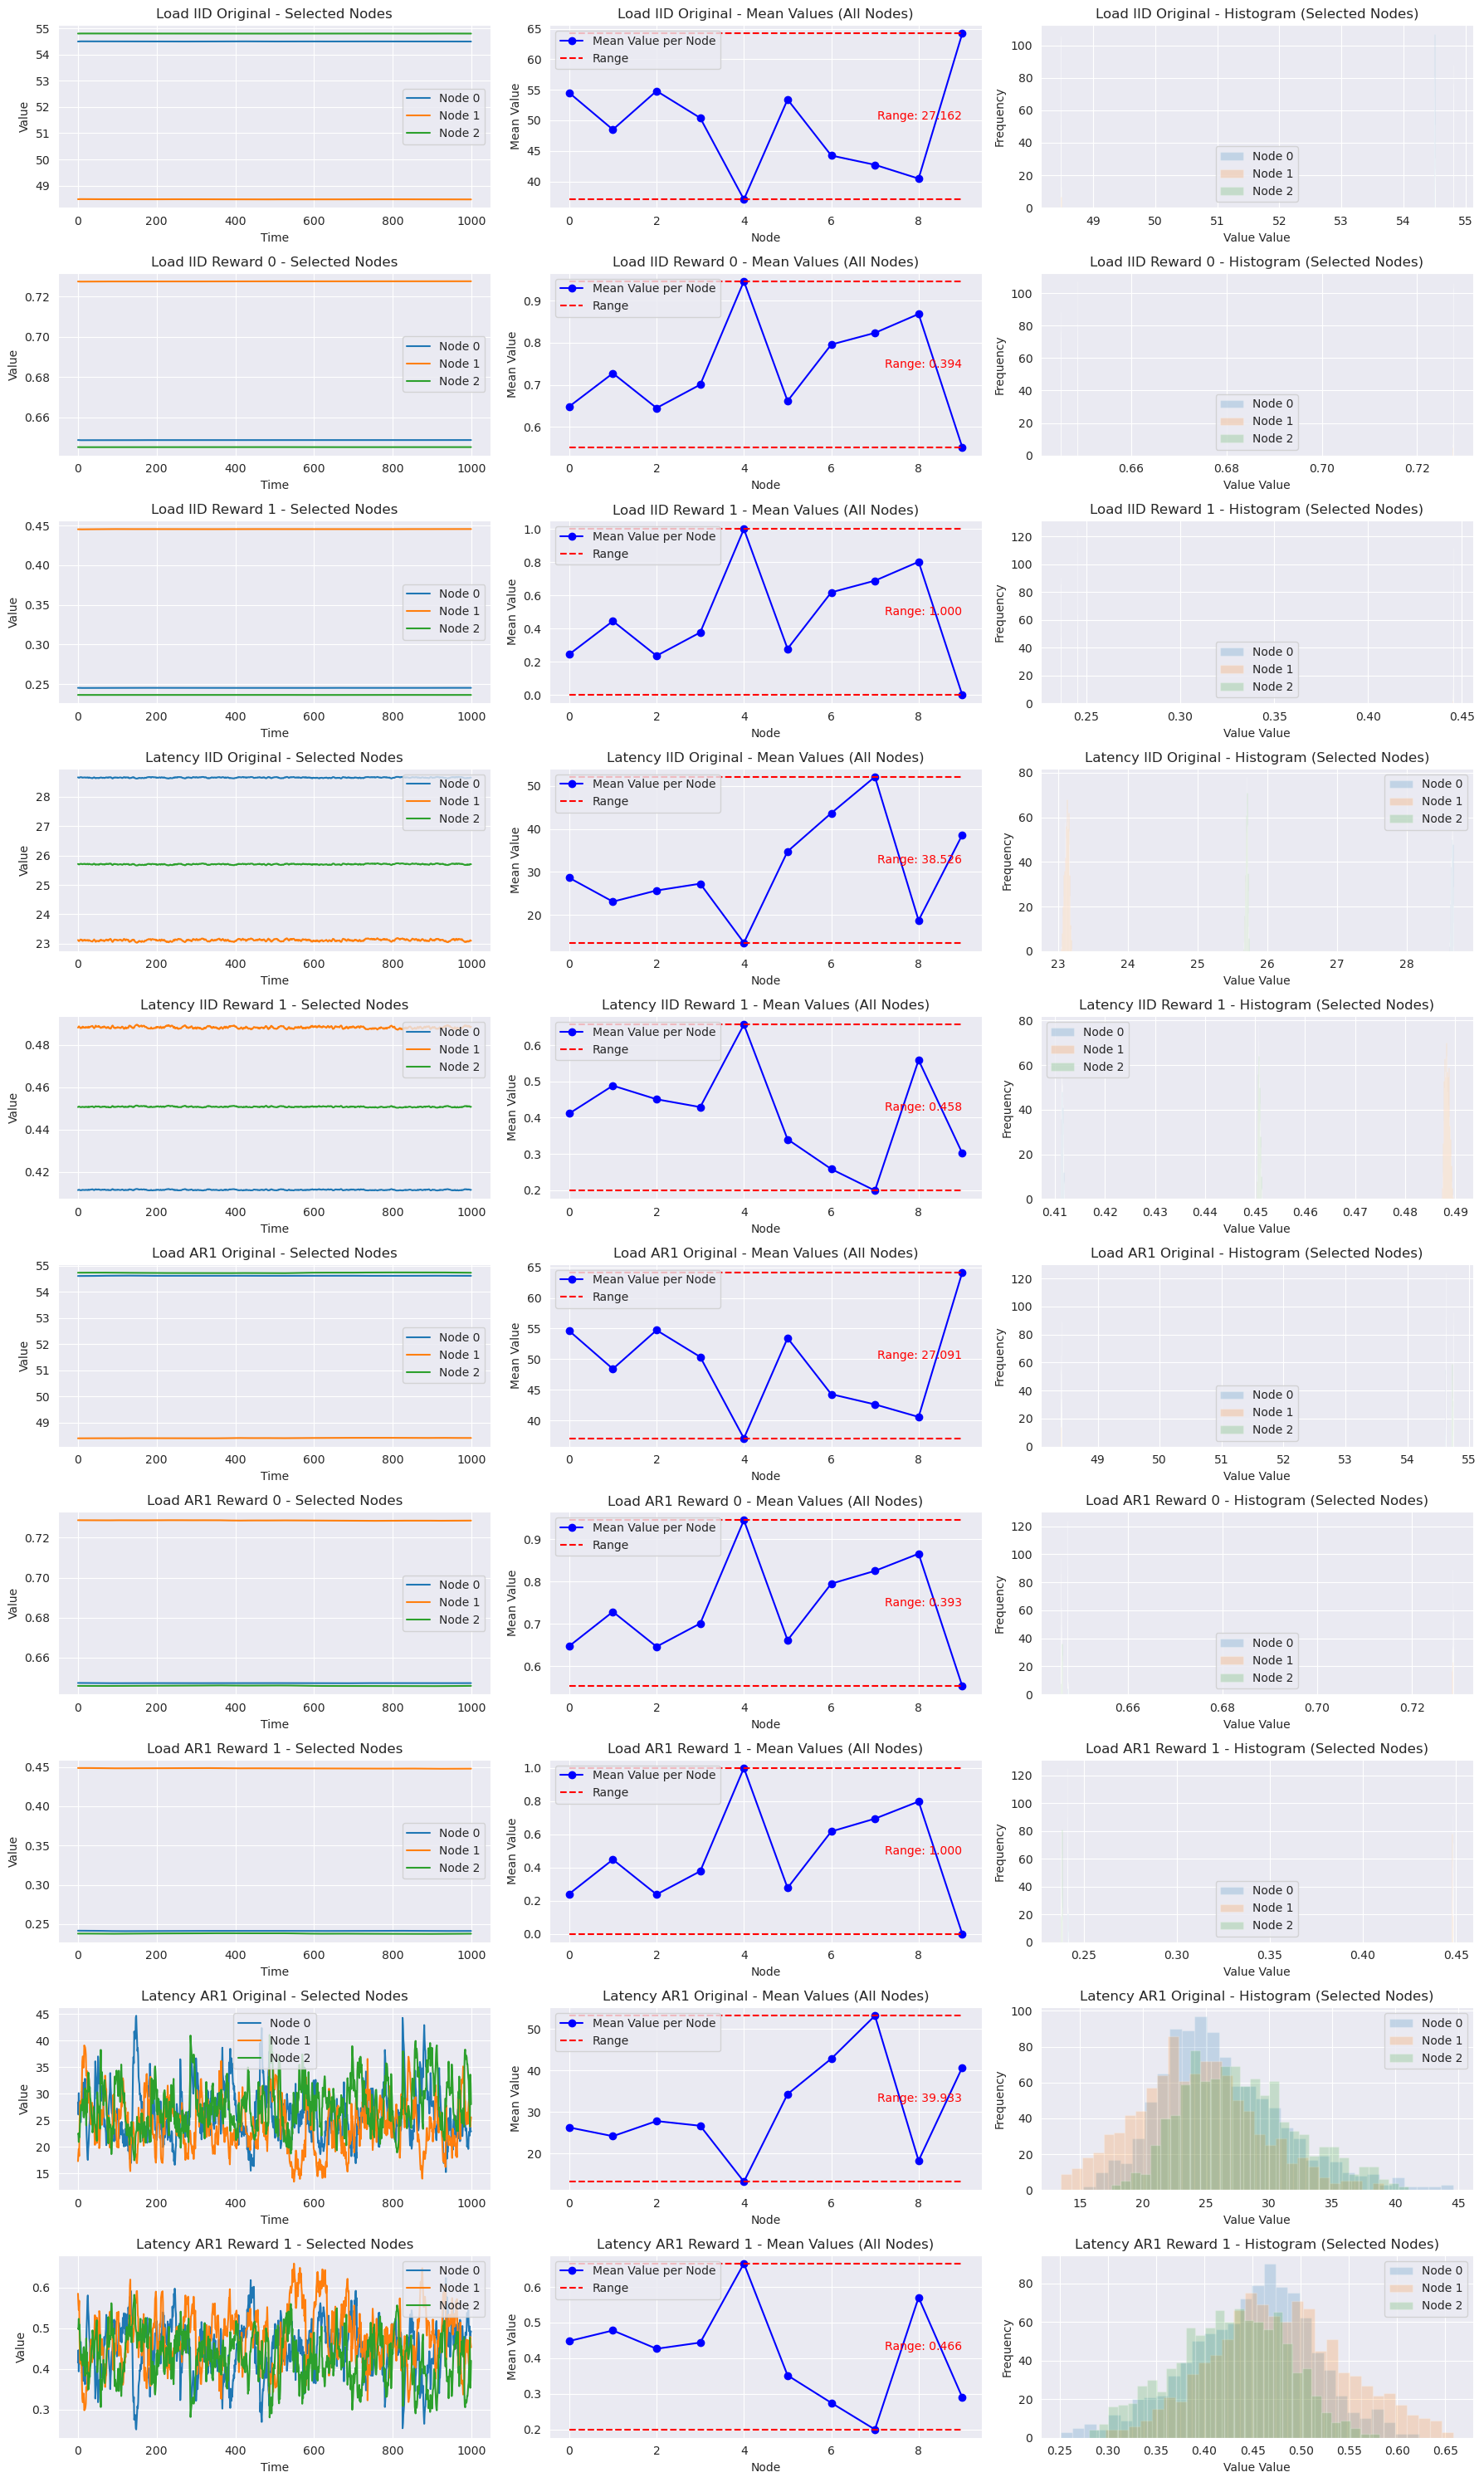

================ GNN Data Manager ================
---------- Reward Data Info ----------
iid_load_original.shape: (10, 1000)
iid_load_pred_reward_0.shape: (10, 1000)
iid_load_pred_reward_1.shape: (10, 1000)
iid_latency_original.shape: (10, 1000)
iid_latency_pred_reward_1.shape: (10, 1000)
ar1_load_original.shape: (10, 1000)
ar1_load_pred_reward_0.shape: (10, 1000)
ar1_load_pred_reward_1.shape: (10, 1000)
ar1_latency_original.shape: (10, 1000)
ar1_latency_pred_reward_1.shape: (10, 1000)
--------------------------------------


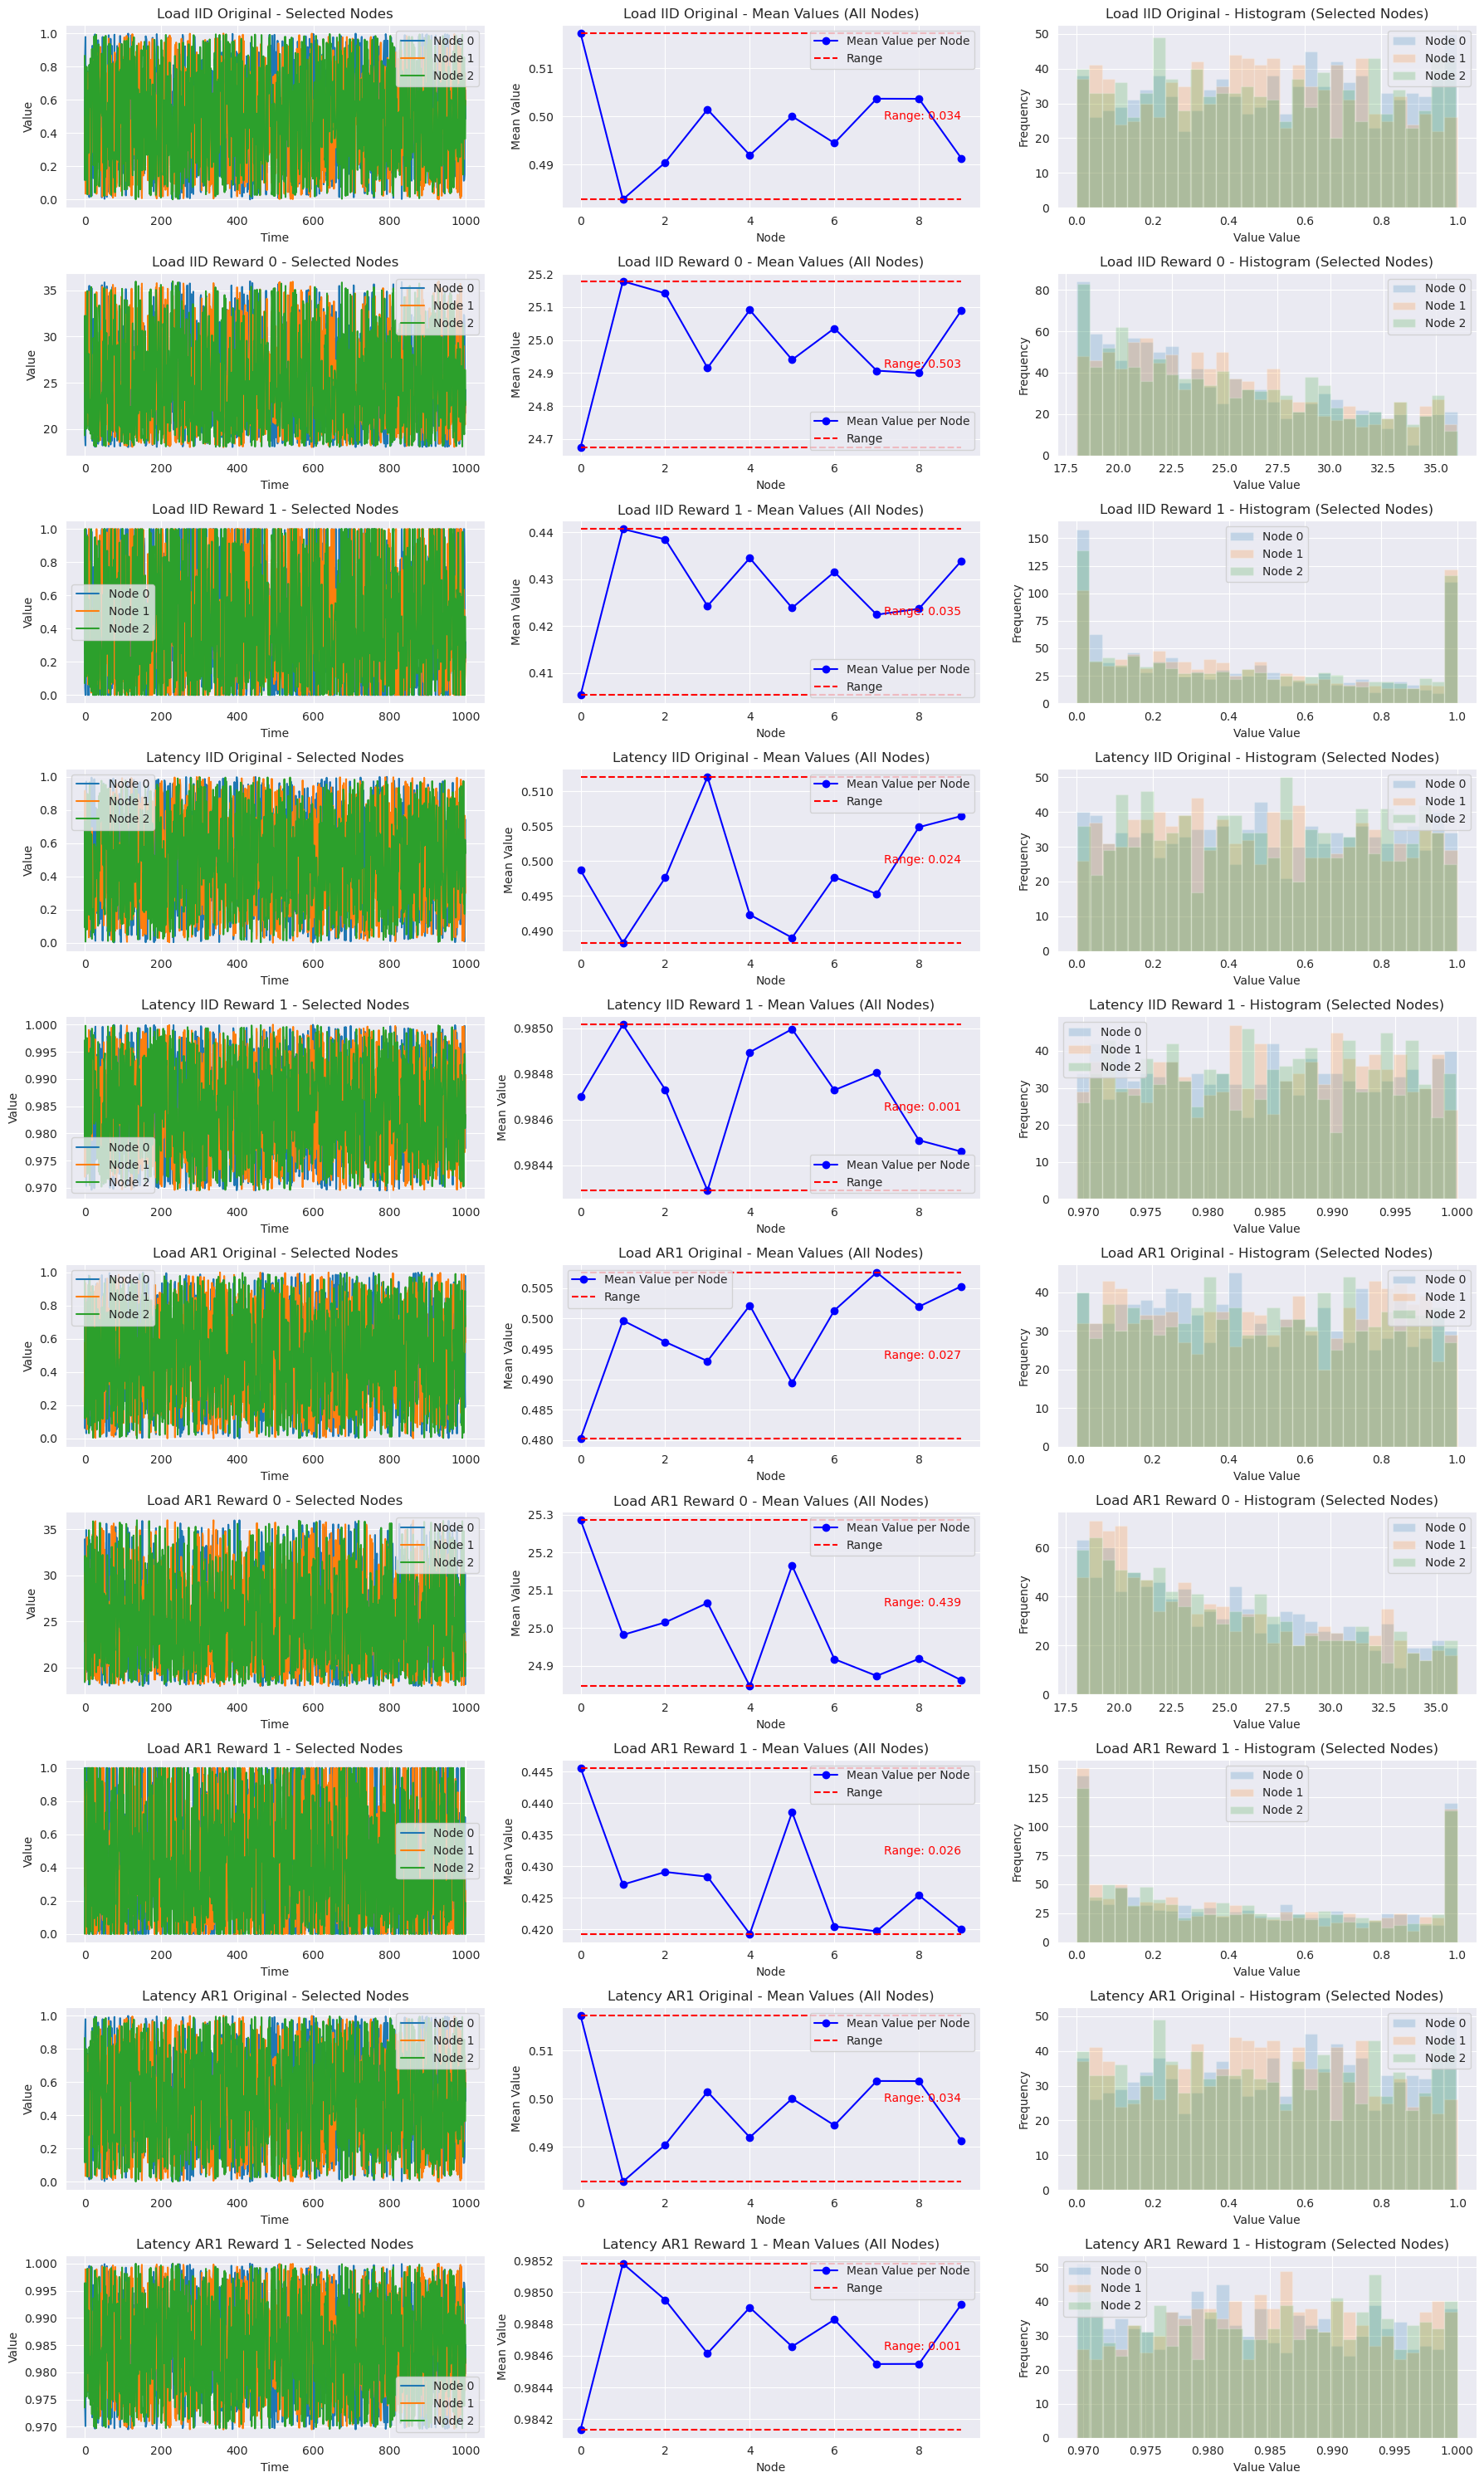

In [34]:
if __name__ == '__main__':
    # 配置管理
    config = DataInit.config_manager()
    
    # 路径管理
    global_path, data_path, load_latency_original_csv_path, rewards_npy_path, models_pkl_path = DataInit.path_manager(config)

    exp4_data_manager = Exp4DataManager(config, data_path, if_print_plot=True)

    # exp4_data_manager = Exp4DataManager(config, data_path)
    
    # 保存数据
    with open(models_pkl_path/f'exp4_data_manager.pkl', 'wb') as f:
        pickle.dump(exp4_data_manager, f)